# Case Study -  MPST: Movie Plot Synopses with Tags

### About Dataset:
=======================

Dataset contains IMDB id, title, plot synopsis, tags for the movies. 

There are 14,828 movies' data in total. 

The split column indicates where the data instance resides in the Train/Dev/Test split.


In [1]:
# importing all necessary modules
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pickle import load,dump

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from collections import Counter
from tqdm import tqdm
import os
from wordcloud import WordCloud, STOPWORDS 

from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
pd.set_option('display.max_colwidth', 300)


from skmultilearn.problem_transform import BinaryRelevance
#from sklearn.model_selection import GridSearchCV
# using module hypopt for grid search hyper-parameter optimization using a validation set
from hypopt import GridSearch
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

In [2]:
df = pd.read_csv("mpst_full_data.csv")
df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,"Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the 'Three Faces of Fear'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl w...","cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a sorcerer who reveled in corrupting the innocent and the spread of despair, neared the end of his mortal days and was dismayed. Consumed by hatred for the living, Nhagruul sold his soul to the demon Lords of the abyss so that his malign spirit would su...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the workplace of Alfred Kralik (James Stewart) and the newly hi Ed\nKlara Novak (Margaret Sullavan). At work they constantly irritate each other, but this daily aggravation is tempered by the fact that each has a secret pen pal with which they trade long...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone's standards, is woken up by his wife Iris early one bright September morning in 1964. Glenn has taken a job as a music teacher at the newly renamed John F. Kennedy High School. He intends his job to be a sabbatical from being a touring musician, duri...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (Al Pacino) claims asylum, in Florida, USA, and is in search of the ""American Dream"" after departing Cuba in the Mariel boatlift of 1980. When questioned by three tough-talking INS officials, they notice a tattoo on Tony's left arm of a black heart wit...","cruelty, murder, dramatic, cult, violence, atmospheric, action, romantic, revenge, sadist",val,imdb


In [3]:
print("The shape of dataframe is {}".format(df.shape))

The shape of dataframe is (14828, 6)


In [4]:
# no null values are present in dataset..
df.isnull().sum()

imdb_id            0
title              0
plot_synopsis      0
tags               0
split              0
synopsis_source    0
dtype: int64

In [5]:
df["split"].value_counts()

train    9489
test     2966
val      2373
Name: split, dtype: int64

## Data Preprocessing And Cleaning

**1. Preprocessing Synopsis**

In [6]:
#using function and stopwords form assignemnt
import nltk
nltk.download('stopwords')
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
  
# we are removing the words from the stop words list: 'no', 'nor', 'not'
from nltk.corpus import stopwords
stop_words = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rdbz3b\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
from tqdm import tqdm

#for train data
preprocessed_synopsis = []
# tqdm is for printing the status bar
for sentance in tqdm(df['plot_synopsis'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stop_words)
    preprocessed_synopsis.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████████| 14828/14828 [01:02<00:00, 237.89it/s]


In [8]:
df["clean_synopsis"] = preprocessed_synopsis

**2. Tags Pre-procesing**

In [9]:
# as most of the tags are comma seprated,
# remooving commas from tags and cleaning them.

tag = list(df['tags'].values)

tag_list = []
for t in tag:
    t = decontracted(t.lower())
    temp = ""
    for j in t.split(','): 
        if 'the' in j.split(): 
            j=j.replace('the','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_') 
    tag_list.append(temp.strip())

In [10]:
# replacing tags with clean_tags
df["clean_tags"] = tag_list

# adding tag_count coloumn for analysis.
df["tag_count"] = df["clean_tags"].apply(lambda x:len(x.split()))
df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,clean_synopsis,clean_tags,tag_count
0,tt0057603,I tre volti della paura,"Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the 'Three Faces of Fear'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl w...","cult, horror, gothic, murder, atmospheric",train,imdb,note synopsis orginal italian release segments certain order boris karloff introduces three horror tales macabre supernatural known three faces fear the telephonerosy michele mercier attractive high priced parisian call girl returns spacious basement apartment evening immediately gets beset seri...,cult horror gothic murder atmospheric,5
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a sorcerer who reveled in corrupting the innocent and the spread of despair, neared the end of his mortal days and was dismayed. Consumed by hatred for the living, Nhagruul sold his soul to the demon Lords of the abyss so that his malign spirit would su...",violence,train,imdb,two thousand years ago nhagruul foul sorcerer reveled corrupting innocent spread despair neared end mortal days dismayed consumed hatred living nhagruul sold soul demon lords abyss malign spirit would survive in excruciating ritual nhagrulls skin flayed pages bones hammered cover diseased blood ...,violence,1
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the workplace of Alfred Kralik (James Stewart) and the newly hi Ed\nKlara Novak (Margaret Sullavan). At work they constantly irritate each other, but this daily aggravation is tempered by the fact that each has a secret pen pal with which they trade long...",romantic,test,imdb,matuschek gift store budapest workplace alfred kralik james stewart newly hi ed klara novak margaret sullavan at work constantly irritate daily aggravation tempered fact secret pen pal trade long soul searching letters romantic correspondence sent back forth alfred klara trade barbs work dream s...,romantic,1
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone's standards, is woken up by his wife Iris early one bright September morning in 1964. Glenn has taken a job as a music teacher at the newly renamed John F. Kennedy High School. He intends his job to be a sabbatical from being a touring musician, duri...","inspiring, romantic, stupid, feel-good",train,imdb,glenn holland morning person anyone standards woken wife iris early one bright september morning 1964 glenn taken job music teacher newly renamed john f kennedy high school he intends job sabbatical touring musician hopes free time compose however soon finds job teacher time consuming first thou...,inspiring romantic stupid feel-good,4
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (Al Pacino) claims asylum, in Florida, USA, and is in search of the ""American Dream"" after departing Cuba in the Mariel boatlift of 1980. When questioned by three tough-talking INS officials, they notice a tattoo on Tony's left arm of a black heart wit...","cruelty, murder, dramatic, cult, violence, atmospheric, action, romantic, revenge, sadist",val,imdb,in may 1980 cuban man named tony montana al pacino claims asylum florida usa search american dream departing cuba mariel boatlift 1980 when questioned three tough talking ins officials notice tattoo tony left arm black heart pitchfork identifies hitman detain camp called freedomtown cubans inclu...,cruelty murder dramatic cult violence atmospheric action romantic revenge sadist,10


In [11]:
df["clean_tags"] = df["clean_tags"].apply(lambda x: x.split())

**3. Pre-processing Title**

In [12]:
from tqdm import tqdm

#for train data
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(df['title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stop_words)
    preprocessed_title.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 14828/14828 [00:00<00:00, 19984.54it/s]


In [13]:
df["clean_title"] = preprocessed_title
df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,clean_synopsis,clean_tags,tag_count,clean_title
0,tt0057603,I tre volti della paura,"Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the 'Three Faces of Fear'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl w...","cult, horror, gothic, murder, atmospheric",train,imdb,note synopsis orginal italian release segments certain order boris karloff introduces three horror tales macabre supernatural known three faces fear the telephonerosy michele mercier attractive high priced parisian call girl returns spacious basement apartment evening immediately gets beset seri...,"[cult, horror, gothic, murder, atmospheric]",5,i tre volti della paura
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a sorcerer who reveled in corrupting the innocent and the spread of despair, neared the end of his mortal days and was dismayed. Consumed by hatred for the living, Nhagruul sold his soul to the demon Lords of the abyss so that his malign spirit would su...",violence,train,imdb,two thousand years ago nhagruul foul sorcerer reveled corrupting innocent spread despair neared end mortal days dismayed consumed hatred living nhagruul sold soul demon lords abyss malign spirit would survive in excruciating ritual nhagrulls skin flayed pages bones hammered cover diseased blood ...,[violence],1,dungeons dragons the book vile darkness
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the workplace of Alfred Kralik (James Stewart) and the newly hi Ed\nKlara Novak (Margaret Sullavan). At work they constantly irritate each other, but this daily aggravation is tempered by the fact that each has a secret pen pal with which they trade long...",romantic,test,imdb,matuschek gift store budapest workplace alfred kralik james stewart newly hi ed klara novak margaret sullavan at work constantly irritate daily aggravation tempered fact secret pen pal trade long soul searching letters romantic correspondence sent back forth alfred klara trade barbs work dream s...,[romantic],1,the shop around corner
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone's standards, is woken up by his wife Iris early one bright September morning in 1964. Glenn has taken a job as a music teacher at the newly renamed John F. Kennedy High School. He intends his job to be a sabbatical from being a touring musician, duri...","inspiring, romantic, stupid, feel-good",train,imdb,glenn holland morning person anyone standards woken wife iris early one bright september morning 1964 glenn taken job music teacher newly renamed john f kennedy high school he intends job sabbatical touring musician hopes free time compose however soon finds job teacher time consuming first thou...,"[inspiring, romantic, stupid, feel-good]",4,mr holland opus
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (Al Pacino) claims asylum, in Florida, USA, and is in search of the ""American Dream"" after departing Cuba in the Mariel boatlift of 1980. When questioned by three tough-talking INS officials, they notice a tattoo on Tony's left arm of a black heart wit...","cruelty, murder, dramatic, cult, violence, atmospheric, action, romantic, revenge, sadist",val,imdb,in may 1980 cuban man named tony montana al pacino claims asylum florida usa search american dream departing cuba mariel boatlift 1980 when questioned three tough talking ins officials notice tattoo tony left arm black heart pitchfork identifies hitman detain camp called freedomtown cubans inclu...,"[cruelty, murder, dramatic, cult, violence, atmospheric, action, romantic, revenge, sadist]",10,scarface


## EDA

### 1. EDA on Tags

In [14]:
df["clean_tags"].iloc[4]

['cruelty',
 'murder',
 'dramatic',
 'cult',
 'violence',
 'atmospheric',
 'action',
 'romantic',
 'revenge',
 'sadist']

In [15]:
df["tag_count"].describe()

count    14828.000000
mean         2.981252
std          2.599900
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         25.000000
Name: tag_count, dtype: float64

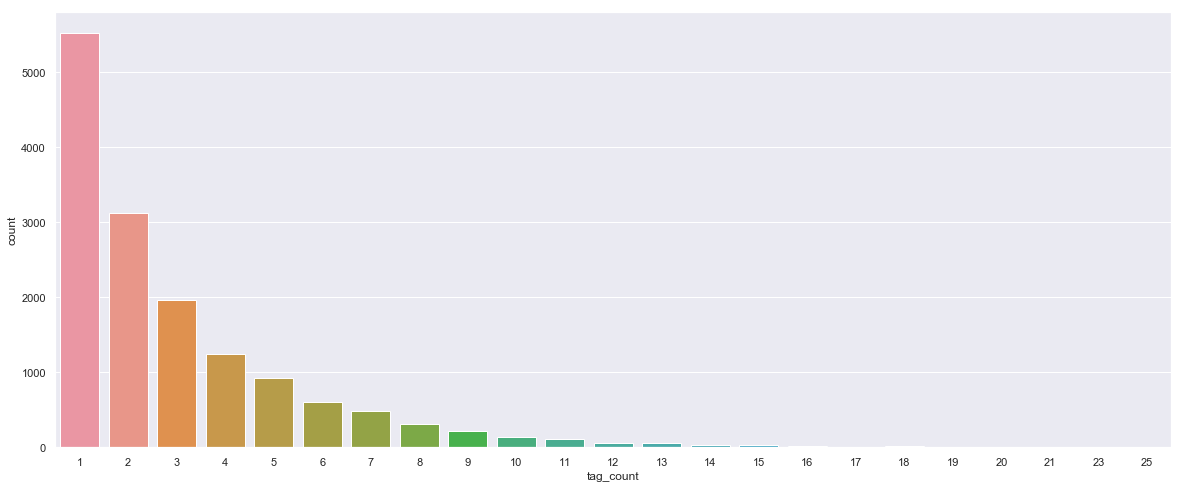

In [16]:
sns.set()
plt.figure(figsize=(20,8))
sns.countplot(x= "tag_count",data =df)

In [17]:
for i in range(1,101):
    print("{}%  --> {}".format(i,np.percentile(df["tag_count"].values,i)))

1%  --> 1.0
2%  --> 1.0
3%  --> 1.0
4%  --> 1.0
5%  --> 1.0
6%  --> 1.0
7%  --> 1.0
8%  --> 1.0
9%  --> 1.0
10%  --> 1.0
11%  --> 1.0
12%  --> 1.0
13%  --> 1.0
14%  --> 1.0
15%  --> 1.0
16%  --> 1.0
17%  --> 1.0
18%  --> 1.0
19%  --> 1.0
20%  --> 1.0
21%  --> 1.0
22%  --> 1.0
23%  --> 1.0
24%  --> 1.0
25%  --> 1.0
26%  --> 1.0
27%  --> 1.0
28%  --> 1.0
29%  --> 1.0
30%  --> 1.0
31%  --> 1.0
32%  --> 1.0
33%  --> 1.0
34%  --> 1.0
35%  --> 1.0
36%  --> 1.0
37%  --> 1.0
38%  --> 2.0
39%  --> 2.0
40%  --> 2.0
41%  --> 2.0
42%  --> 2.0
43%  --> 2.0
44%  --> 2.0
45%  --> 2.0
46%  --> 2.0
47%  --> 2.0
48%  --> 2.0
49%  --> 2.0
50%  --> 2.0
51%  --> 2.0
52%  --> 2.0
53%  --> 2.0
54%  --> 2.0
55%  --> 2.0
56%  --> 2.0
57%  --> 2.0
58%  --> 2.0
59%  --> 3.0
60%  --> 3.0
61%  --> 3.0
62%  --> 3.0
63%  --> 3.0
64%  --> 3.0
65%  --> 3.0
66%  --> 3.0
67%  --> 3.0
68%  --> 3.0
69%  --> 3.0
70%  --> 3.0
71%  --> 3.0
72%  --> 4.0
73%  --> 4.0
74%  --> 4.0
75%  --> 4.0
76%  --> 4.0
77%  --> 4.0
78%  -->

- Since on an **avg. 3 tags** are present per movie.
- some movies have tags like descriptions. So ignoring that tags.
- From above percentile, **only 1% of tags have length more than 14.**
- **We are considering only data points having tag_count less than 12 as it covers 98% data points**

In [18]:
#df = df.loc[df["tag_count"]<=12]

In [19]:
print(len(df))
df.head()

14828


,imdb_id,title,plot_synopsis,tags,split,synopsis_source,clean_synopsis,clean_tags,tag_count,clean_title
0,tt0057603,I tre volti della paura,"Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the 'Three Faces of Fear'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl w...","cult, horror, gothic, murder, atmospheric",train,imdb,note synopsis orginal italian release segments certain order boris karloff introduces three horror tales macabre supernatural known three faces fear the telephonerosy michele mercier attractive high priced parisian call girl returns spacious basement apartment evening immediately gets beset seri...,"[cult, horror, gothic, murder, atmospheric]",5,i tre volti della paura
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a sorcerer who reveled in corrupting the innocent and the spread of despair, neared the end of his mortal days and was dismayed. Consumed by hatred for the living, Nhagruul sold his soul to the demon Lords of the abyss so that his malign spirit would su...",violence,train,imdb,two thousand years ago nhagruul foul sorcerer reveled corrupting innocent spread despair neared end mortal days dismayed consumed hatred living nhagruul sold soul demon lords abyss malign spirit would survive in excruciating ritual nhagrulls skin flayed pages bones hammered cover diseased blood ...,[violence],1,dungeons dragons the book vile darkness
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the workplace of Alfred Kralik (James Stewart) and the newly hi Ed\nKlara Novak (Margaret Sullavan). At work they constantly irritate each other, but this daily aggravation is tempered by the fact that each has a secret pen pal with which they trade long...",romantic,test,imdb,matuschek gift store budapest workplace alfred kralik james stewart newly hi ed klara novak margaret sullavan at work constantly irritate daily aggravation tempered fact secret pen pal trade long soul searching letters romantic correspondence sent back forth alfred klara trade barbs work dream s...,[romantic],1,the shop around corner
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone's standards, is woken up by his wife Iris early one bright September morning in 1964. Glenn has taken a job as a music teacher at the newly renamed John F. Kennedy High School. He intends his job to be a sabbatical from being a touring musician, duri...","inspiring, romantic, stupid, feel-good",train,imdb,glenn holland morning person anyone standards woken wife iris early one bright september morning 1964 glenn taken job music teacher newly renamed john f kennedy high school he intends job sabbatical touring musician hopes free time compose however soon finds job teacher time consuming first thou...,"[inspiring, romantic, stupid, feel-good]",4,mr holland opus
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (Al Pacino) claims asylum, in Florida, USA, and is in search of the ""American Dream"" after departing Cuba in the Mariel boatlift of 1980. When questioned by three tough-talking INS officials, they notice a tattoo on Tony's left arm of a black heart wit...","cruelty, murder, dramatic, cult, violence, atmospheric, action, romantic, revenge, sadist",val,imdb,in may 1980 cuban man named tony montana al pacino claims asylum florida usa search american dream departing cuba mariel boatlift 1980 when questioned three tough talking ins officials notice tattoo tony left arm black heart pitchfork identifies hitman detain camp called freedomtown cubans inclu...,"[cruelty, murder, dramatic, cult, violence, atmospheric, action, romantic, revenge, sadist]",10,scarface


**More analysis on tags.**

In [20]:
tags = []
for t in df["clean_tags"].values:
    tags.extend(t)
        
# collecting all tags into list
cnt = Counter(tags)

In [21]:
len(cnt)

71

In [22]:
tag_df = pd.DataFrame(data=cnt.items(),columns=["tags","num"])
tag_df.sort_values(by="num",ascending=False,inplace=True)
tag_df.describe()

,num
count,71.000000
mean,622.619718
std,1017.688759
min,37.000000
25%,119.000000
50%,233.000000
75%,580.500000
max,5782.000000


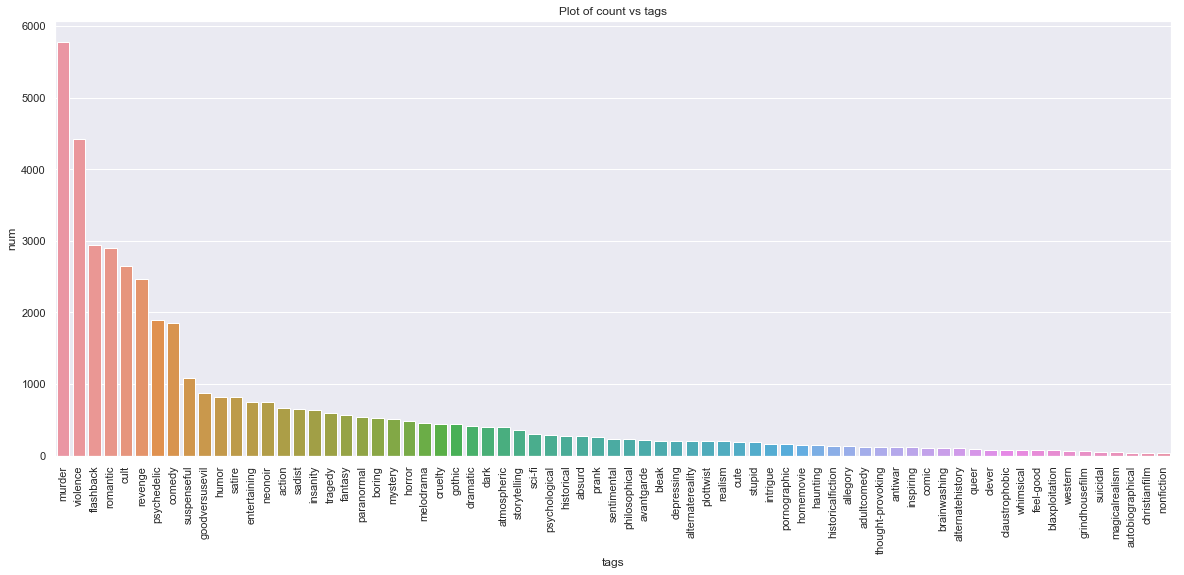

In [23]:
sns.set()
plt.figure(figsize=(20,8))
sns.barplot(x = "tags",y = "num",data=tag_df)
plt.xticks(rotation='vertical')
plt.title("Plot of count vs tags")
plt.show()

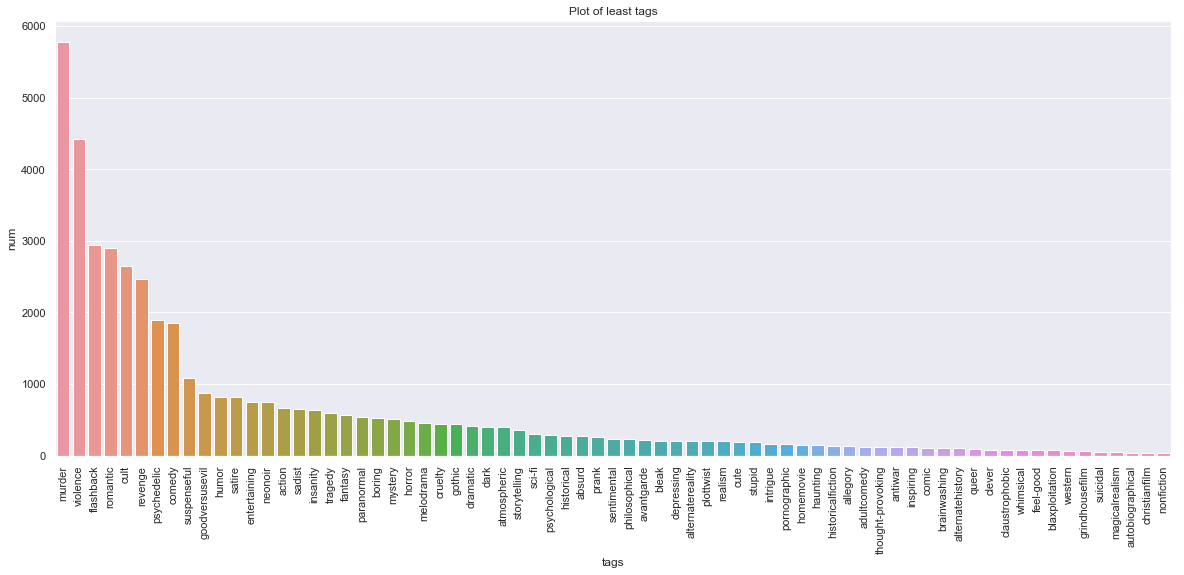

In [24]:
sns.set()
plt.figure(figsize=(20,8))
sns.barplot(x = "tags",y = "num",data=tag_df)
plt.xticks(rotation='vertical')
plt.title("Plot of least tags")
plt.show()

In [25]:
print("Top 10 most occuring tags \n")
print(cnt.most_common(10))

Top 10 most occuring tags 

[('murder', 5782), ('violence', 4426), ('flashback', 2937), ('romantic', 2906), ('cult', 2647), ('revenge', 2468), ('psychedelic', 1897), ('comedy', 1859), ('suspenseful', 1086), ('goodversusevil', 875)]


In [26]:
total_tags = list(set(tags))
print("Total number of unique tags {}".format(len(total_tags)))

Total number of unique tags 71


**Distribution of top 50 tags**

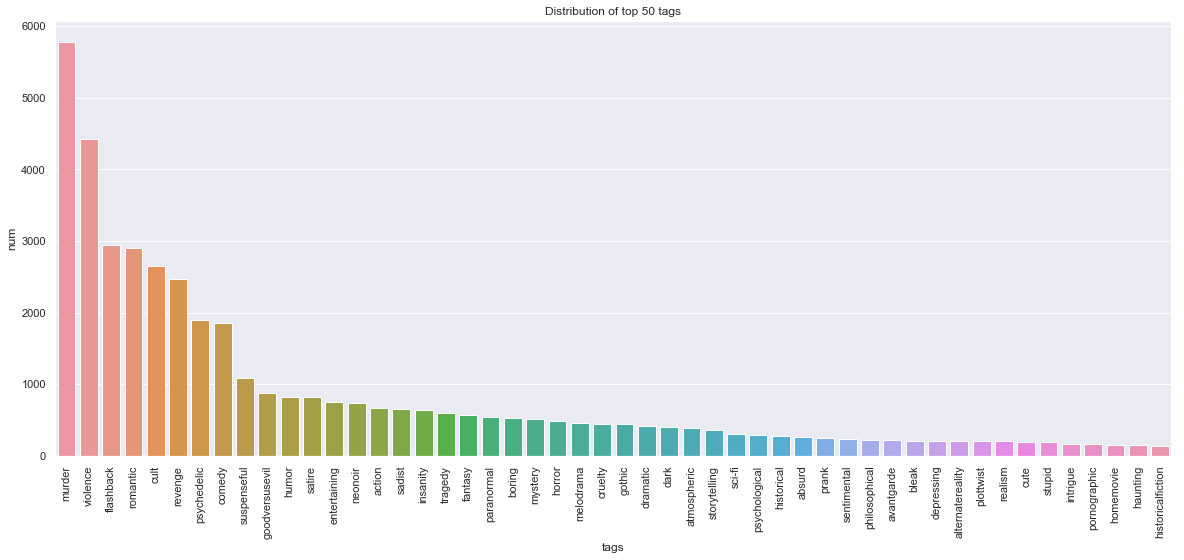

In [27]:
sns.set()
plt.figure(figsize=(20,8))
sns.barplot(x = "tags",y = "num",data=tag_df[:50])
plt.xticks(rotation='vertical')
plt.title("Distribution of top 50 tags",)
plt.show()

#### About tags:
- murder is the most frequent tag with frequency of 5646
- whimsical	 is the least frequent tag with least frequeny of 2
- Total number of **71 unique tags are present.**

**WordCloud Plot**

In [28]:
def Plot_wordcloud(word):
    
    """
     Function for plotting wordcloud.
    """
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop_words,
                          min_font_size = 10).generate(word) 
    # plot the WordCloud image                        
    plt.figure(figsize = (8,8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.title("Word Cloud Plot for tags")
    plt.show()

Word Cloud plot for tags


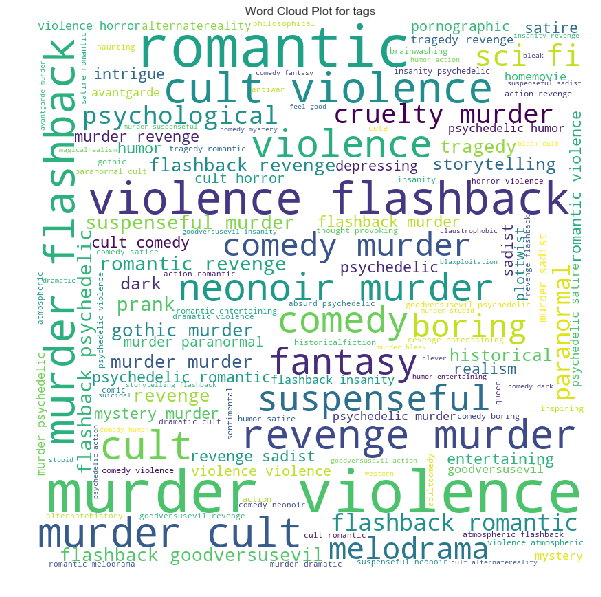

In [29]:
words = " "
for ew in df["clean_tags"]:
    for w in ew:
        words = words+ " "+ w
    
# plotting word cloud
print("Word Cloud plot for tags")
Plot_wordcloud(words)

### 2. EDA on Movie_plots

In [30]:
import nltk
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
  

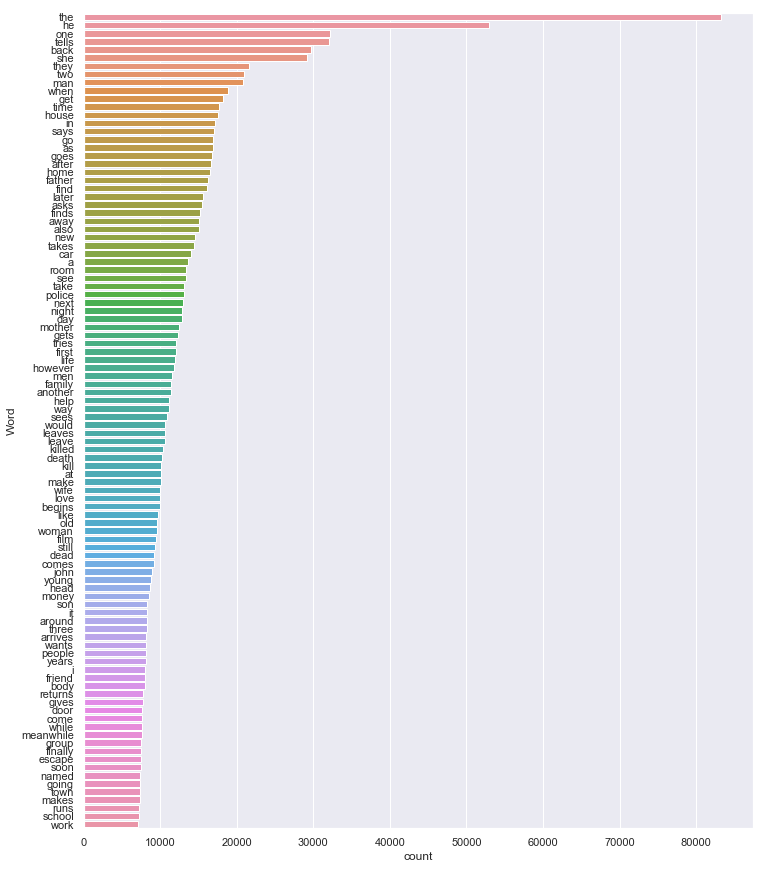

In [31]:
freq_words(df['clean_synopsis'], 100)

In [32]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [33]:
# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df['clean_synopsis'] = df['clean_synopsis'].apply(lambda x: remove_stopwords(x))

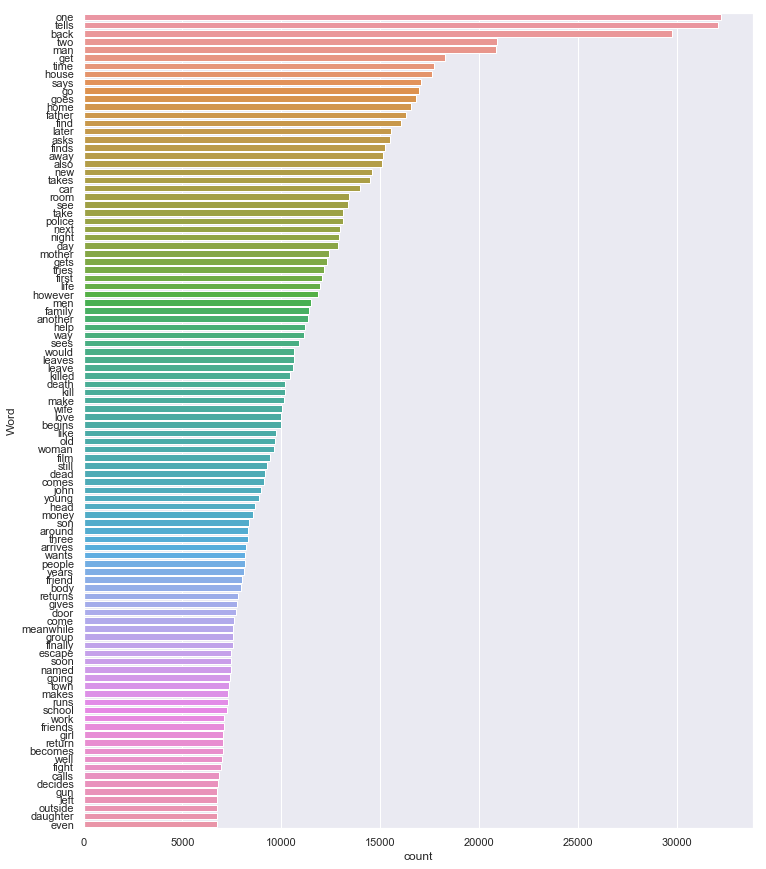

In [34]:
freq_words(df['clean_synopsis'], 100)

In [35]:
df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,clean_synopsis,clean_tags,tag_count,clean_title
0,tt0057603,I tre volti della paura,"Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the 'Three Faces of Fear'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl w...","cult, horror, gothic, murder, atmospheric",train,imdb,note synopsis orginal italian release segments certain order boris karloff introduces three horror tales macabre supernatural known three faces fear telephonerosy michele mercier attractive high priced parisian call girl returns spacious basement apartment evening immediately gets beset series s...,"[cult, horror, gothic, murder, atmospheric]",5,i tre volti della paura
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a sorcerer who reveled in corrupting the innocent and the spread of despair, neared the end of his mortal days and was dismayed. Consumed by hatred for the living, Nhagruul sold his soul to the demon Lords of the abyss so that his malign spirit would su...",violence,train,imdb,two thousand years ago nhagruul foul sorcerer reveled corrupting innocent spread despair neared end mortal days dismayed consumed hatred living nhagruul sold soul demon lords abyss malign spirit would survive excruciating ritual nhagrulls skin flayed pages bones hammered cover diseased blood bec...,[violence],1,dungeons dragons the book vile darkness
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the workplace of Alfred Kralik (James Stewart) and the newly hi Ed\nKlara Novak (Margaret Sullavan). At work they constantly irritate each other, but this daily aggravation is tempered by the fact that each has a secret pen pal with which they trade long...",romantic,test,imdb,matuschek gift store budapest workplace alfred kralik james stewart newly hi ed klara novak margaret sullavan work constantly irritate daily aggravation tempered fact secret pen pal trade long soul searching letters romantic correspondence sent back forth alfred klara trade barbs work dream some...,[romantic],1,the shop around corner
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone's standards, is woken up by his wife Iris early one bright September morning in 1964. Glenn has taken a job as a music teacher at the newly renamed John F. Kennedy High School. He intends his job to be a sabbatical from being a touring musician, duri...","inspiring, romantic, stupid, feel-good",train,imdb,glenn holland morning person anyone standards woken wife iris early one bright september morning 1964 glenn taken job music teacher newly renamed john f kennedy high school intends job sabbatical touring musician hopes free time compose however soon finds job teacher time consuming first thought...,"[inspiring, romantic, stupid, feel-good]",4,mr holland opus
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (Al Pacino) claims asylum, in Florida, USA, and is in search of the ""American Dream"" after departing Cuba in the Mariel boatlift of 1980. When questioned by three tough-talking INS officials, they notice a tattoo on Tony's left arm of a black heart wit...","cruelty, murder, dramatic, cult, violence, atmospheric, action, romantic, revenge, sadist",val,imdb,may 1980 cuban man named tony montana al pacino claims asylum florida usa search american dream departing cuba mariel boatlift 1980 questioned three tough talking ins officials notice tattoo tony left arm black heart pitchfork identifies hitman detain camp called freedomtown cubans including ton...,"[cruelty, murder, dramatic, cult, violence, atmospheric, action, romantic, revenge, sadist]",10,scarface


In [36]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['clean_tags'])

# transform target variable
y = multilabel_binarizer.transform(df['clean_tags'])

In [37]:
y.shape

(14828, 71)

## Data Splitting

- Since imdb_id and synopsis_source dont have much relation with output label tags
- Tags of the movie has very much dependancy on plot_synopsis and litlte bit on title.

In [38]:
df.columns

Index(['imdb_id', 'title', 'plot_synopsis', 'tags', 'split', 'synopsis_source',
       'clean_synopsis', 'clean_tags', 'tag_count', 'clean_title'],
      dtype='object')

In [39]:
df.drop(['imdb_id', 'title', 'plot_synopsis', 'tags','synopsis_source'],axis = 1,inplace=True)

In [40]:
df.head()

,split,clean_synopsis,clean_tags,tag_count,clean_title
0,train,note synopsis orginal italian release segments certain order boris karloff introduces three horror tales macabre supernatural known three faces fear telephonerosy michele mercier attractive high priced parisian call girl returns spacious basement apartment evening immediately gets beset series s...,"[cult, horror, gothic, murder, atmospheric]",5,i tre volti della paura
1,train,two thousand years ago nhagruul foul sorcerer reveled corrupting innocent spread despair neared end mortal days dismayed consumed hatred living nhagruul sold soul demon lords abyss malign spirit would survive excruciating ritual nhagrulls skin flayed pages bones hammered cover diseased blood bec...,[violence],1,dungeons dragons the book vile darkness
2,test,matuschek gift store budapest workplace alfred kralik james stewart newly hi ed klara novak margaret sullavan work constantly irritate daily aggravation tempered fact secret pen pal trade long soul searching letters romantic correspondence sent back forth alfred klara trade barbs work dream some...,[romantic],1,the shop around corner
3,train,glenn holland morning person anyone standards woken wife iris early one bright september morning 1964 glenn taken job music teacher newly renamed john f kennedy high school intends job sabbatical touring musician hopes free time compose however soon finds job teacher time consuming first thought...,"[inspiring, romantic, stupid, feel-good]",4,mr holland opus
4,val,may 1980 cuban man named tony montana al pacino claims asylum florida usa search american dream departing cuba mariel boatlift 1980 questioned three tough talking ins officials notice tattoo tony left arm black heart pitchfork identifies hitman detain camp called freedomtown cubans including ton...,"[cruelty, murder, dramatic, cult, violence, atmospheric, action, romantic, revenge, sadist]",10,scarface


**splitting data as per split**

In [41]:
# splitting data as per split
test_df,train_df,val_df = df.groupby(by = "split")

test_df,train_df,val_df = test_df[1],train_df[1],val_df[1]

In [42]:
test_df.drop("split",axis=1,inplace=True)
train_df.drop("split",axis=1,inplace=True)
val_df.drop("split",axis=1,inplace=True)

In [43]:
# multilabel_binarizer fitted on whole data.

train_multilabel_y = multilabel_binarizer.transform(train_df['clean_tags'])
test_multilabel_y = multilabel_binarizer.transform(test_df['clean_tags'])
val_multilabel_y = multilabel_binarizer.transform(val_df['clean_tags'])

print(train_df.shape," ",train_multilabel_y.shape)
print(test_df.shape," ",test_multilabel_y.shape)
print(val_df.shape," ",val_multilabel_y.shape)

(9489, 4)   (9489, 71)
(2966, 4)   (2966, 71)
(2373, 4)   (2373, 71)


## Vectorizing Text data

### Plot Synopsis

**1. BOW**

In [44]:
count_vectorizer = CountVectorizer(min_df=10,max_df=0.8,ngram_range=(1,4),max_features=10000)
#fit using train data
count_vectorizer.fit(train_df["clean_synopsis"].values)
essay_feature = count_vectorizer.get_feature_names()


# for train data
synopsis_bow = count_vectorizer.transform(train_df["clean_synopsis"].values)
# for test data
test_synopsis_bow = count_vectorizer.transform(test_df["clean_synopsis"].values)
# for val data
val_synopsis_bow = count_vectorizer.transform(val_df["clean_synopsis"].values)

print(synopsis_bow.shape)
print(test_synopsis_bow.shape)
print(val_synopsis_bow.shape)

(9489, 10000)
(2966, 10000)
(2373, 10000)


**2. TFIDF**

In [45]:
tfidf_vectorizer = TfidfVectorizer(min_df=10,max_df=0.8,ngram_range=(1,4),max_features=10000)
#fit using train data
tfidf_vectorizer.fit(train_df["clean_synopsis"].values)

# for train data
synopsis_tfidf = tfidf_vectorizer.transform(train_df["clean_synopsis"].values)
# for test data
test_synopsis_tfidf = tfidf_vectorizer.transform(test_df["clean_synopsis"].values)
# for val data
val_synopsis_tfidf = tfidf_vectorizer.transform(val_df["clean_synopsis"].values)


print(synopsis_tfidf.shape)
print(test_synopsis_tfidf.shape)
print(val_synopsis_tfidf.shape)

(9489, 10000)
(2966, 10000)
(2373, 10000)


**3. Avg W2V**

In [46]:
# using standard glove vector file. A file containing 6B words.

import pandas as pd
import csv

words = pd.read_table("glove.6B.300d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

In [47]:
def vec(w):
    """
    This function returns 300 dimetional vector for a given word.
    """
    return words.loc[w].as_matrix()

In [49]:
# using all the words from countvectorizer get_feature_names.
# as using all the words form training data was taking approx. 1 day to process.

model = {}
for word in count_vectorizer.get_feature_names():
    if word in words.index.values:
        model[word] = vec(word)

In [50]:
# for train data
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in train_df["clean_synopsis"].values: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in model:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)
print("Completed for tain..\n")
print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))
print("*"*70)
    
# for test data
test_avg_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in test_df["clean_synopsis"].values: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in model:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_avg_w2v_vectors.append(vector)
print("Completed for test...\n")
print(len(test_avg_w2v_vectors))
print(len(test_avg_w2v_vectors[0]))
print("*"*70)

# for val data
val_avg_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in val_df["clean_synopsis"].values: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in model:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    val_avg_w2v_vectors.append(vector)
print("completed for val...\n")
print(len(val_avg_w2v_vectors))
print(len(val_avg_w2v_vectors[0]))
print("*"*70)

Completed for tain..

9489
300
**********************************************************************
Completed for test...

2966
300
**********************************************************************
completed for val...

2373
300
**********************************************************************


**4. TFIDF Avg W2V**

In [51]:
# using all the words from tfidfvectorizer get_feature_names.
# as using all the words form training data was taking approx. 1 day to process.

model = {}
for word in tfidf_vectorizer.get_feature_names():
    if word in words.index.values:
        model[word] = vec(word)

In [52]:
# for train data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(train_df["clean_synopsis"].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in train_df["clean_synopsis"].values: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in model) and (word in tfidf_words):
            vect = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vect * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

9489
300


In [53]:

# for test data
test_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_df["clean_synopsis"].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in model) and (word in tfidf_words):
            vect = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vect * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_vectors.append(vector)

print(len(test_tfidf_w2v_vectors))
print(len(test_tfidf_w2v_vectors[0]))


# for val data
val_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(val_df["clean_synopsis"].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in model) and (word in tfidf_words):
            vect = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vect * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    val_tfidf_w2v_vectors.append(vector)

print(len(val_tfidf_w2v_vectors))
print(len(val_tfidf_w2v_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████████| 2966/2966 [01:36<00:00, 30.60it/s]


2966
300


100%|██████████████████████████████████████████████████████████████████████████████| 2373/2373 [01:26<00:00, 27.46it/s]


2373
300


### 2. Title

**1. BOW**

In [48]:
title_count_vectorizer = CountVectorizer(max_df=0.8,ngram_range=(1,4),max_features=10000)
#fit using train data
title_count_vectorizer.fit(train_df["clean_title"].values)


# for train data
title_bow = title_count_vectorizer.transform(train_df["clean_title"].values)
# for test data
test_title_bow = title_count_vectorizer.transform(test_df["clean_title"].values)
# for val data
val_title_bow = title_count_vectorizer.transform(val_df["clean_title"].values)


**2. TFIDF**

In [49]:
title_tfidf_vectorizer = TfidfVectorizer(max_df=0.8,ngram_range=(1,4),max_features=10000)
#fit using train data
title_tfidf_vectorizer.fit(train_df["clean_title"].values)

# for train data
title_tfidf = title_tfidf_vectorizer.transform(train_df["clean_title"].values)
# for test data
test_title_tfidf = title_tfidf_vectorizer.transform(test_df["clean_title"].values)
# for val data
val_title_tfidf = title_tfidf_vectorizer.transform(val_df["clean_title"].values)



**3. Avg W2V**

In [56]:
# using all the words from countvectorizer get_feature_names.
# as using all the words form training data was taking approx. 1 day to process.

model = {}
for word in title_count_vectorizer.get_feature_names():
    if word in words.index.values:
        model[word] = vec(word)

In [57]:
# for train data
title_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in train_df["clean_title"].values: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in model:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_avg_w2v_vectors.append(vector)
print("Completed for tain..\n")
print(len(title_avg_w2v_vectors))
print(len(title_avg_w2v_vectors[0]))
print("*"*70)
    
# for test data
test_title_avg_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in test_df["clean_title"].values: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in model:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_title_avg_w2v_vectors.append(vector)
print("Completed for test...\n")
print(len(test_title_avg_w2v_vectors))
print(len(test_title_avg_w2v_vectors[0]))
print("*"*70)

# for val data
val_title_avg_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in val_df["clean_title"].values: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in model:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    val_title_avg_w2v_vectors.append(vector)
print("completed for val...\n")
print(len(val_title_avg_w2v_vectors))
print(len(val_title_avg_w2v_vectors[0]))
print("*"*70)

Completed for tain..

9489
300
**********************************************************************
Completed for test...

2966
300
**********************************************************************
completed for val...

2373
300
**********************************************************************


**4. TFIDF W2V**

In [58]:
# using all the words from countvectorizer get_feature_names.
# as using all the words form training data was taking approx. 1 day to process.

model = {}
for word in title_tfidf_vectorizer.get_feature_names():
    if word in words.index.values:
        model[word] = vec(word)

In [59]:
# for train data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(train_df["clean_title"].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in train_df["clean_title"].values: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in model) and (word in tfidf_words):
            vect = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vect * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    title_tfidf_w2v_vectors.append(vector)

print(len(title_tfidf_w2v_vectors))
print(len(title_tfidf_w2v_vectors[0]))



# for test data
test_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_df["clean_title"].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in model) and (word in tfidf_words):
            vect = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vect * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_title_tfidf_w2v_vectors.append(vector)

print(len(test_title_tfidf_w2v_vectors))
print(len(test_title_tfidf_w2v_vectors[0]))


# for val data
val_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(val_df["clean_title"].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in model) and (word in tfidf_words):
            vect = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vect * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    val_title_tfidf_w2v_vectors.append(vector)

print(len(val_title_tfidf_w2v_vectors))
print(len(val_title_tfidf_w2v_vectors[0]))


9489
300


100%|███████████████████████████████████████████████████████████████████████████| 2966/2966 [00:00<00:00, 41084.78it/s]


2966
300


100%|███████████████████████████████████████████████████████████████████████████| 2373/2373 [00:00<00:00, 39118.83it/s]


2373
300


## Machine Learning Models

### 1. Making sets ready

In [50]:
from scipy.sparse import hstack

# for bow
set1 = hstack((title_bow,synopsis_bow))
set1_t = hstack((test_title_bow,test_synopsis_bow))
set1_v = hstack((val_title_bow,val_synopsis_bow))

# for tfidf
set2 = hstack((title_tfidf,synopsis_tfidf))
set2_t = hstack((test_title_tfidf,test_synopsis_tfidf))
set2_v = hstack((val_title_tfidf,val_synopsis_tfidf))

In [59]:
title_avg_w2v_vectors = np.array(title_avg_w2v_vectors)
avg_w2v_vectors = np.array(avg_w2v_vectors)

test_title_avg_w2v_vectors = np.array(test_title_avg_w2v_vectors)
test_avg_w2v_vectors = np.array(test_avg_w2v_vectors)

val_title_avg_w2v_vectors = np.array(val_title_avg_w2v_vectors)
val_avg_w2v_vectors = np.array(val_avg_w2v_vectors)



title_tfidf_w2v_vectors = np.array(title_tfidf_w2v_vectors)
tfidf_w2v_vectors = np.array(tfidf_w2v_vectors)

test_title_tfidf_w2v_vectors = np.array(test_title_tfidf_w2v_vectors)
test_tfidf_w2v_vectors = np.array(test_tfidf_w2v_vectors)

val_title_tfidf_w2v_vectors = np.array(val_title_tfidf_w2v_vectors)
val_tfidf_w2v_vectors = np.array(val_tfidf_w2v_vectors)

In [60]:
for i in title_avg_w2v_vectors,avg_w2v_vectors:
    print(i.shape)

(9489, 300)
(9489, 300)


In [61]:
# for avg_w2v
set3 = np.hstack((title_avg_w2v_vectors,avg_w2v_vectors))
set3_t = np.hstack((test_title_avg_w2v_vectors,test_avg_w2v_vectors))
set3_v = np.hstack((val_title_avg_w2v_vectors,val_avg_w2v_vectors))

# for tfidf-w2v
set4 = np.hstack((title_tfidf_w2v_vectors,tfidf_w2v_vectors))
set4_t = np.hstack((test_title_tfidf_w2v_vectors,test_tfidf_w2v_vectors))
set4_v = np.hstack((val_title_tfidf_w2v_vectors,val_tfidf_w2v_vectors))

In [56]:
!pip install scikit-multilearn
!pip install hypopt

In [51]:
from skmultilearn.problem_transform import BinaryRelevance
#from sklearn.model_selection import GridSearchCV
# using module hypopt for grid search hyper-parameter optimization using a validation set
from hypopt import GridSearch
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

### 2. Multilabel k Nearest Neighbours

- Predicting for tfidf validation data.
- changing parameters manually.

In [64]:
from skmultilearn.adapt import MLkNN

param_grid = dict(
    k =  [2,5,7,11] ,
    s = [0.5, 0.7, 1.0]
)

# using gridsearch instead of GridsearchCV to use validation data provided.
grid = GridSearch(model=MLkNN(),param_grid=param_grid)
grid.fit(set2,train_multilabel_y,set2_v,val_multilabel_y,scoring='f1_micro')

MLkNN(ignore_first_neighbours=0, k=5, s=0.5)

In [65]:
grid_predictions = grid.predict(set2_t)
print(grid.best_params)
print(grid.best_estimator_)
print("="*60)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,grid_predictions)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,grid_predictions, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, grid_predictions, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,grid_predictions)))

{'k': 5, 's': 0.5}
MLkNN(ignore_first_neighbours=0, k=5, s=0.5)
Hamming loss 0.046484571623944614
Micro F1 score 0.20122399020807835


C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro F1 score 0.06120069024093342
Accuracy is 0.04821308159136885


### 2. Tuning LR (OvR) with SGD

**1. Using TFIDF**

In [66]:
# using grid search instead of GridsearchCV to use validation data provided.

warnings.filterwarnings("ignore")

param_grid  = {"estimator__alpha":[0.00000001,0.0000001,0.000001,0.00001,0.0001]}
ovr=OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', random_state=0))

In [67]:
grid = GridSearch(model=ovr,param_grid=param_grid)
grid.fit(set2,train_multilabel_y,set2_v,val_multilabel_y,scoring='f1_micro')

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [68]:
grid_predictions = grid.predict(set2_t)
print(grid.best_params)
print(grid.best_estimator_)
print("="*60)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,grid_predictions)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,grid_predictions, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, grid_predictions, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,grid_predictions)))

{'estimator__alpha': 1e-05}
OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)
Hamming loss 0.04863571177571158
Micro F1 score 0.2941419710544453
Macro F1 score 0.11419345538009947
Accuracy is 0.0576534052596089


- The micro f1 score obtianed here is **0.294**. The threshold considered here is 0.5 to determine the class labels. 
- Lets vary threshold and check f1 score.
- As most of the values are near to zero threshold of 0.1 gives best f1 score of 0.322.

In [71]:
grid_ = grid.predict_proba(set2_t)
y_pred_new = (grid_ >= 0.1).astype(int)
print("Hamming loss   {}".format(metrics.hamming_loss(test_multilabel_y,y_pred_new)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,y_pred_new, average = 'micro')))


Hamming loss   0.06723143988679209
Micro F1 score 0.32251890133027084


**2. Using BOW**

In [72]:
# using grid search instead of GridsearchCV to use validation data provided.
grid = GridSearch(model=ovr,param_grid=param_grid)
grid.fit(set1,train_multilabel_y,set1_v,val_multilabel_y,scoring='f1_micro')

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [73]:
grid_predictions = grid.predict(set1_t)
print(grid.best_params)
print(grid.best_estimator_)
print("="*60)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,grid_predictions)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,grid_predictions, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, grid_predictions, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,grid_predictions)))

{'estimator__alpha': 1e-05}
OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)
Hamming loss 0.06244954555383549
Micro F1 score 0.27642365887207704
Macro F1 score 0.12608136804350067
Accuracy is 0.02933243425488874


**3. Using Avg-W2v**

In [74]:
param_grid  = {"estimator__alpha":[0.000001,0.00001,0.0001,0.001,0.1]}
ovr=OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', random_state=0))

grid = GridSearch(model=ovr,param_grid=param_grid)
grid.fit(set3,train_multilabel_y,set3_v,val_multilabel_y,scoring='f1_micro')

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [75]:
grid_predictions = grid.predict(set3_t)
print(grid.best_params)
print(grid.best_estimator_)
print("="*60)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,grid_predictions)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,grid_predictions, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, grid_predictions, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,grid_predictions)))

{'estimator__alpha': 1e-05}
OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)
Hamming loss 0.060383881169688396
Micro F1 score 0.25966464834653
Macro F1 score 0.11037549362275119
Accuracy is 0.031018206338503034


**4. Using TFIDF-W2V**

In [76]:
param_grid  = {"estimator__alpha":[0.000001,0.00001,0.0001,0.001,0.1]}
ovr=OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', random_state=0))

grid = GridSearch(model=ovr,param_grid=param_grid)
grid.fit(set4,train_multilabel_y,set4_v,val_multilabel_y,scoring='f1_micro')

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [77]:
grid_predictions = grid.predict(set4_t)
print(grid.best_params)
print(grid.best_estimator_)
print("="*60)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,grid_predictions)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,grid_predictions, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, grid_predictions, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,grid_predictions)))

{'estimator__alpha': 1e-05}
OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)
Hamming loss 0.06653813643831974
Micro F1 score 0.1997715591090805
Macro F1 score 0.0855799352833085
Accuracy is 0.016857720836142953


### 3. Tuning Lr. SVM (OvR) with SGD

**1. Using TFIDF**

In [116]:
#Build the model
param_grid  = {"estimator__alpha":[0.000001,0.00001,0.0001,0.001,0.1]}
ovr = OneVsRestClassifier(SGDClassifier())
grid = GridSearch(model=ovr,param_grid=param_grid)
grid.fit(set2,train_multilabel_y,set2_v,val_multilabel_y,scoring='f1_micro')

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [117]:
grid_predictions = grid.predict(set2_t)
print(grid.best_params)
print(grid.best_estimator_)
print("="*60)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,grid_predictions)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,grid_predictions, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, grid_predictions, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,grid_predictions)))

{'estimator__alpha': 1e-05}
OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)
Hamming loss 0.05091506557890838
Micro F1 score 0.2949763282482904
Macro F1 score 0.12133612266134111
Accuracy is 0.04720161834120027


**2. Using BOW**

In [118]:
#Build the model
ovr = OneVsRestClassifier(SGDClassifier())
grid = GridSearch(model=ovr,param_grid=param_grid)
grid.fit(set1,train_multilabel_y,set1_v,val_multilabel_y,scoring='f1_micro')

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-06, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [119]:
grid_predictions = grid.predict(set1_t)
print(grid.best_params)
print(grid.best_estimator_)
print("="*60)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,grid_predictions)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,grid_predictions, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, grid_predictions, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,grid_predictions)))

{'estimator__alpha': 1e-06}
OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-06, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)
Hamming loss 0.06241155632378221
Micro F1 score 0.2892217835703856
Macro F1 score 0.12167124808696435
Accuracy is 0.027646662171274445


**3. Using Avg-W2v**

In [120]:
#Build the model
ovr = OneVsRestClassifier(SGDClassifier())
grid = GridSearch(model=ovr,param_grid=param_grid)
grid.fit(set3,train_multilabel_y,set3_v,val_multilabel_y,scoring='f1_micro')

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [121]:
grid_predictions = grid.predict(set3_t)
print(grid.best_params)
print(grid.best_estimator_)
print("="*60)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,grid_predictions)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,grid_predictions, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, grid_predictions, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,grid_predictions)))

{'estimator__alpha': 0.0001}
OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)
Hamming loss 0.06432526378771618
Micro F1 score 0.29152719665271964
Macro F1 score 0.08251070831729267
Accuracy is 0.009777478084962913


**4. Using TFIDF W2V**

In [122]:
#Build the model
ovr = OneVsRestClassifier(SGDClassifier())
grid = GridSearch(model=ovr,param_grid=param_grid)
grid.fit(set4,train_multilabel_y,set4_v,val_multilabel_y,scoring='f1_micro')

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [123]:
grid_predictions = grid.predict(set4_t)
print(grid.best_params)
print(grid.best_estimator_)
print("="*60)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,grid_predictions)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,grid_predictions, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, grid_predictions, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,grid_predictions)))

{'estimator__alpha': 0.0001}
OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)
Hamming loss 0.06152355807128679
Micro F1 score 0.26227081198041224
Macro F1 score 0.08341625118981194
Accuracy is 0.015509103169251517


### 4. Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

In [89]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

param_grid = {"estimator__C" :[1,10,100,1000,10000,100000]}

grid = GridSearch(model=clf,param_grid=param_grid)
grid.fit(set2,train_multilabel_y,set2_v,val_multilabel_y,scoring='f1_micro')

OneVsRestClassifier(estimator=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [90]:
grid_predictions = grid.predict(set2_t)
print(grid.best_params)
print(grid.best_estimator_)
print("="*60)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,grid_predictions)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,grid_predictions, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, grid_predictions, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,grid_predictions)))

{'estimator__C': 1000}
OneVsRestClassifier(estimator=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)
Hamming loss 0.04758151064173307
Micro F1 score 0.3005723858718414
Macro F1 score 0.11482950562866459
Accuracy is 0.05832771409305462


Text(0.5, 1.0, 'Best threshold ')

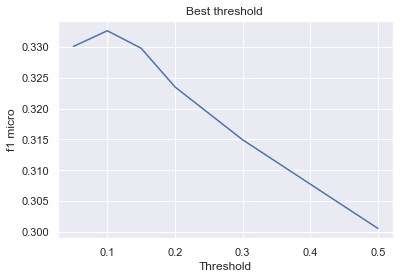

In [91]:
threshold = [0.05,0.1,0.15,0.2,0.3,0.5]
f1_micro = []
for i in threshold:
    y_pred_prob = grid.predict_proba(set2_t)
    y_pred_new = (y_pred_prob >= i).astype(int)
    f1_micro.append(metrics.f1_score(test_multilabel_y,y_pred_new, average = 'micro'))

plt.plot(threshold,f1_micro)
plt.xlabel("Threshold")
plt.ylabel("f1 micro")
plt.title("Best threshold ")

**Best threshold found 0.1**

In [92]:
y_pred_prob = grid.predict_proba(set2_t)
y_pred_new = (y_pred_prob >= 0.1).astype(int)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,y_pred_new)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,y_pred_new, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, y_pred_new, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,y_pred_new)))

Hamming loss 0.0580095542913584
Micro F1 score 0.3326048951048951
Macro F1 score 0.14743755585286164
Accuracy is 0.03573836817262306


## 5. Kernel Trick

**1. NMF**

In [52]:
n_components = 10


def print_top_words(model, feature_names, n_top_words = 10):
    print(model.components_.shape)
    topic_dict = dict()
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        topics = [feature_names[i]
                                 for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx] = topics
        print(message)
        print(topics)
        print()
    return topic_dict

In [53]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

tfidf_vectorizer = TfidfVectorizer(max_df=0.8,ngram_range=(1,4),max_features=10000,stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(train_df["clean_synopsis"].values)
nmf = NMF(n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5).fit(tfidf)


In [54]:
print("\nTopics in NMF model :")

tfidf_feature_names = tfidf_vectorizer.get_feature_names()

topic_dict = print_top_words(nmf, tfidf_feature_names)
 


Topics in NMF model :
(10, 10000)
Topic #0: 
['man', 'tells', 'father', 'house', 'police', 'family', 'home', 'film', 'mother', 'time']

Topic #1: 
['tom', 'jerry', 'mouse', 'cat', 'spike', 'butch', 'cheese', 'baby', 'tail', 'lightning']

Topic #2: 
['jack', 'sally', 'cal', 'rose', 'tells jack', 'adrian', 'greg', 'giant', 'jennifer', 'peter']

Topic #3: 
['nick', 'libby', 'gatsby', 'kate', 'bryce', 'russell', 'julie', 'frank', 'philip', 'casey']

Topic #4: 
['joe', 'frank', 'connie', 'kong', 'sara', 'peyton', 'japanese', 'jed', 'business', 'pat']

Topic #5: 
['bugs', 'sam', 'daffy', 'elmer', 'rabbit', 'bunny', 'rocky', 'porky', 'duck', 'cartoon']

Topic #6: 
['harry', 'voldemort', 'dumbledore', 'hermione', 'ron', 'linda', 'karl', 'archie', 'perry', 'harmony']

Topic #7: 
['charlie', 'charlie brown', 'linus', 'snoopy', 'brown', 'lucy', 'porky', 'patty', 'woodstock', 'marcie']

Topic #8: 
['david', 'alan', 'susan', 'tells david', 'david tells', 'amy', 'elizabeth', 'uncle', 'michael', 'li

In [59]:
def get_glove(review):
    """
    This function returns glove_vector for each topic label.
    
    @returns = wighted glove vector. i.e  nmf_values * glove_vector
    
    """
    topic_glove = np.zeros(300)
    topic_array = nmf.transform(tfidf_vectorizer.transform([review]))
    topic_array = topic_array.reshape(10)
    for ew in topic_dict[np.argmax(topic_array)]:
        if ew in words.index.values:
            topic_glove += vec(ew)
    return topic_glove/len(topic_array)

In [64]:
train_glove = []
for er in train_df["clean_synopsis"].values:
    train_glove.append(get_glove(er))

train_glove =  np.vstack(train_glove)
print(train_glove.shape)


(9489, 300)


In [73]:
# for val data

val_glove = []
for er in tqdm(val_df["clean_synopsis"].values):
    val_glove.append(get_glove(er))

val_glove =  np.vstack(val_glove)
print(val_glove.shape)

# for test data

test_glove = []
for er in tqdm(test_df["clean_synopsis"].values):
    test_glove.append(get_glove(er))

test_glove =  np.vstack(test_glove)
print(test_glove.shape)

**Topic Number**

In [66]:
train_nmf = nmf.transform(tfidf)
dominant_topic = np.argmax(train_nmf, axis=1)

val_nmf = nmf.transform(tfidf_vectorizer.transform(val_df["clean_synopsis"].values))
val_dominant_topic = np.argmax(val_nmf, axis=1)

test_nmf = nmf.transform(tfidf_vectorizer.transform(test_df["clean_synopsis"].values))
test_dominant_topic = np.argmax(test_nmf, axis=1)

In [67]:
dominant_topic = dominant_topic.reshape((dominant_topic.shape[0],1))
val_dominant_topic = val_dominant_topic.reshape((val_dominant_topic.shape[0],1))
test_dominant_topic = test_dominant_topic.reshape((test_dominant_topic.shape[0],1))

from sklearn.preprocessing import StandardScaler
std = StandardScaler().fit(dominant_topic)
dominant_topic = std.transform(dominant_topic)
test_dominant_topic = std.transform(test_dominant_topic)
val_dominant_topic = std.transform(val_dominant_topic)

C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


**Model Preperation**


tfidf_vector + glove_vector + topic_number ==> Model

In [68]:
set2 = hstack((synopsis_tfidf,train_nmf,train_glove,dominant_topic))
set2_t = hstack((test_synopsis_tfidf,test_nmf,test_glove,test_dominant_topic))
set2_v = hstack((val_synopsis_tfidf,val_nmf,val_glove,val_dominant_topic))

In [69]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

param_grid = {"estimator__C" :[1,10,80,100,120,1000,10000]}

grid = GridSearch(model=clf,param_grid=param_grid)
grid.fit(set2,train_multilabel_y,set2_v,val_multilabel_y,scoring='f1_micro')

OneVsRestClassifier(estimator=LogisticRegression(C=120, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [70]:
grid_predictions = grid.predict(set2_t)
print(grid.best_params)
print(grid.best_estimator_)
print("="*60)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,grid_predictions)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,grid_predictions, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, grid_predictions, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,grid_predictions)))

{'estimator__C': 120}
OneVsRestClassifier(estimator=LogisticRegression(C=120, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)
Hamming loss 0.04747704025908655
Micro F1 score 0.30346941619060885


C:\Users\rdbz3b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro F1 score 0.10088588366936783
Accuracy is 0.06102494942683749


Text(0.5, 1.0, 'Best threshold ')

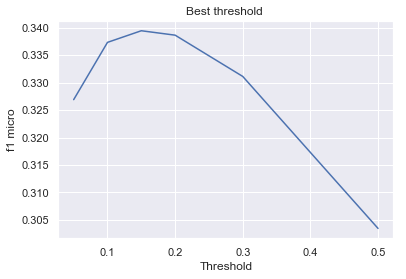

In [71]:
threshold = [0.05,0.1,0.15,0.2,0.3,0.5]
f1_micro = []
for i in threshold:
    y_pred_prob = grid.predict_proba(set2_t)
    y_pred_new = (y_pred_prob >= i).astype(int)
    f1_micro.append(metrics.f1_score(test_multilabel_y,y_pred_new, average = 'micro'))

plt.plot(threshold,f1_micro)
plt.xlabel("Threshold")
plt.ylabel("f1 micro")
plt.title("Best threshold ")

**Best threshold 0.15**

In [72]:
y_pred_prob = grid.predict_proba(set2_t)
y_pred_new = (y_pred_prob >= 0.15).astype(int)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,y_pred_new)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,y_pred_new, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, y_pred_new, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,y_pred_new)))

Hamming loss 0.06142383634239693
Micro F1 score 0.33941065318420915
Macro F1 score 0.14454684643064483
Accuracy is 0.031018206338503034


### 6. Topic Modelling using SKlearn

**Feature engineering using topic modelling**

In [94]:
doc_term_matrix

<9489x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2245197 stored elements in Compressed Sparse Row format>

In [95]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=10, random_state=42)  
LDA.fit(doc_term_matrix)  

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

**Top 20 topics found**

In [96]:
for i,topic in enumerate(LDA.components_):  
    print(f'Top 10 words for topic #{i}:')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['new', 'time', 'home', 'film', 'family', 'police', 'house', 'father', 'tells', 'man']


Top 10 words for topic #1:
['heathcliff', 'sir henry', 'alejandro', 'wee', 'axel', 'skye', 'zane', 'riddick', 'hanna', 'nate']


Top 10 words for topic #2:
['rambo', 'macbeth', 'vinny', 'lizzie', 'pooja', 'elmer', 'goku', 'porky', 'daffy', 'bugs']


Top 10 words for topic #3:
['turtles', 'charlie', 'sal', 'vijay', 'malik', 'snoopy', 'charlie brown', 'hercules', 'linus', 'ravi']


Top 10 words for topic #4:
['biff', 'brandi', 'nic', 'giorgio', 'kabir', 'gant', 'susanna', 'snow', 'tex', 'snow white']


Top 10 words for topic #5:
['jai', 'ripley', 'kirk', 'cinderella', 'pakistan', 'spider man', 'joker', 'charley', 'superman', 'batman']


Top 10 words for topic #6:
['milady', 'lilith', 'richelieu', 'musketeers', 'artagnan', 'que', 'van helsing', 'helsing', 'holmes', 'dracula']


Top 10 words for topic #7:
['killjoy', 'iago', 'bosko', 'attila', 'elwood', 'nemo', 'poe', 'phoebe

In [97]:
topic_values = LDA.transform(doc_term_matrix)  

**Model Preperation**

Transforming test and cv data

In [98]:
test_doc_term_matrix = tfidf.transform(test_df["clean_synopsis"].values)
val_doc_term_matrix = tfidf.transform(val_df["clean_synopsis"].values)

In [99]:
test_topic_values = LDA.transform(test_doc_term_matrix)  
val_topic_values = LDA.transform(val_doc_term_matrix)  

print(topic_values.shape)
print(test_topic_values.shape)
print(val_topic_values.shape)

(9489, 10)
(2966, 10)
(2373, 10)


In [100]:
#set2 = hstack((title_tfidf,synopsis_tfidf,topic_values))
#set2_t = hstack((test_title_tfidf,test_synopsis_tfidf,test_topic_values))
#set2_v = hstack((val_title_tfidf,val_synopsis_tfidf,val_topic_values))

set2 = hstack((synopsis_tfidf,topic_values))
set2_t = hstack((test_synopsis_tfidf,test_topic_values))
set2_v = hstack((val_synopsis_tfidf,val_topic_values))

In [101]:
print(set2.shape,train_multilabel_y.shape)
print(set2_t.shape,test_multilabel_y.shape)
print(set2_v.shape,val_multilabel_y.shape)

(9489, 10010) (9489, 71)
(2966, 10010) (2966, 71)
(2373, 10010) (2373, 71)


In [102]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

param_grid = {"estimator__C" :[1,10,100,1000,10000]}

grid = GridSearch(model=clf,param_grid=param_grid)
grid.fit(set2,train_multilabel_y,set2_v,val_multilabel_y,scoring='f1_micro')

OneVsRestClassifier(estimator=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [103]:
grid_predictions = grid.predict(set2_t)
print(grid.best_params)
print(grid.best_estimator_)
print("="*60)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,grid_predictions)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,grid_predictions, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, grid_predictions, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,grid_predictions)))

{'estimator__C': 100}
OneVsRestClassifier(estimator=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)
Hamming loss 0.04699742622966389
Micro F1 score 0.3059120555438671
Macro F1 score 0.10271829536037799
Accuracy is 0.06035064059339177


Text(0.5, 1.0, 'Best threshold ')

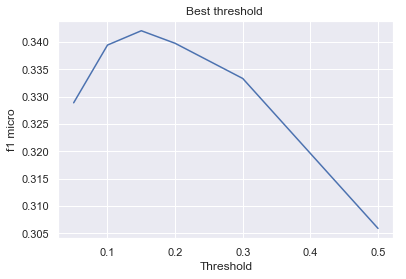

In [104]:
threshold = [0.05,0.1,0.15,0.2,0.3,0.5]
f1_micro = []
for i in threshold:
    y_pred_prob = grid.predict_proba(set2_t)
    y_pred_new = (y_pred_prob >= i).astype(int)
    f1_micro.append(metrics.f1_score(test_multilabel_y,y_pred_new, average = 'micro'))

plt.plot(threshold,f1_micro)
plt.xlabel("Threshold")
plt.ylabel("f1 micro")
plt.title("Best threshold ")

**Best threshold 0.15**

In [105]:
y_pred_prob = grid.predict_proba(set2_t)
y_pred_new = (y_pred_prob >= 0.15).astype(int)
print("Hamming loss {}".format(metrics.hamming_loss(test_multilabel_y,y_pred_new)))
print("Micro F1 score {}".format(metrics.f1_score(test_multilabel_y,y_pred_new, average = 'micro')))
print("Macro F1 score {}".format(metrics.f1_score(test_multilabel_y, y_pred_new, average = 'macro')))
print("Accuracy is {}".format(metrics.accuracy_score(test_multilabel_y,y_pred_new)))

Hamming loss 0.06160428518515001
Micro F1 score 0.3420398640766851
Macro F1 score 0.14548383480226829
Accuracy is 0.03236682400539447


- Best score of 0.342 is obtined when threshold is changed form 0.5 to 0.15.
- By dropping title increase in micro_f1 score found.

### Inferance

In [108]:
def pre_process(sentance):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stop_words)
    return sent.lower()

def predict_tag(plot,title = "",threshold = 1.5):
    """
    This funtion considers only tfidf vectorization because best performance was observed in that.
    Passing movie plot is compulsary.
    
    """
    plot = pre_process(plot)
    title = pre_process(title)
    plot = [w for w in plot.split() if not w in stop_words]
    plot = " ".join(plot)
    plot_topic = LDA.transform(tfidf.transform([plot]))
    set_ = hstack((tfidf_vectorizer.transform([plot]),plot_topic))
    y_ = grid.predict_proba(set_)
    y_new = (y_ >= threshold).astype(int)
    return multilabel_binarizer.inverse_transform(y_new)

**Lets do some inferance to check what the f1 score of 0.342 means practically**

#### 1. Frozen 2 
Actual tags Drama/Fantasy

In [109]:
plot = """
    Elsa the Snow Queen and her sister Anna embark on an adventure far away from the kingdom of Arendelle. They are joined by friends, Kristoff, Olaf, and Sven.
        """
predict_tag(plot,threshold=0.15)

[('fantasy', 'psychedelic')]

#### 2. The Conjuring 2
Actual Tags : Mystery/Thriller

In [111]:
plot = """
        A single mother seeks the help of occult investigators Ed and Lorraine Warren when she and her children witness strange,
        paranormal events in their house.
        """
predict_tag(plot,threshold=0.15)

[('murder', 'paranormal', 'psychedelic')]

#### 3. The Godfather
Actual tags: Drama/Crime

In [112]:
plot = """
        Don Vito Corleone, head of a mafia family, decides to hand over his empire to his youngest son Michael. 
        However, his decision unintentionally puts the lives of his loved ones in grave danger.
        """
predict_tag(plot,threshold=0.15)

[('murder', 'revenge', 'tragedy', 'violence')]

### Observations: 
======================

1. TFIDF is found to be best vectorizer among all.
2. Best **micro f1 score** was found in case of **Logistic Regression wiht topic modelling of 0.342**
3. On EDA, it is found that 50% of plot synopsis have tags less than 2
4. **Increase in f1 score** found when change threshold was changed from 0.5 to lower values. this is expected as most of the probabilities values are smaller.
5. During Inferance most of the tags predicted were correct as per source on internet.
6. Performance can be improoved further with more data points.

### Summary:
=================

In [77]:
from prettytable import PrettyTable
summary = PrettyTable()

In [78]:
summary.field_names = ["Model", "Vectorizer","Threshold","Hamming Loss","micro f1 score","macro f1 score","Accuracy"]
summary.add_row(["Multilabel kNN","TFIDF Vectorizer",0.5,0.046,0.201,0.061,0.048])
summary.add_row(["LR (ovr)","TFIDF Vectorizer",0.5,0.048,0.294,0.114,0.057])
summary.add_row(["LR (ovr)","Count Vectorizer",0.5,0.062,0.276,0.126,0.029])
summary.add_row(["LR (ovr)","Avg-w2v",0.5,0.060,0.259,0.110,0.031])
summary.add_row(["LR (ovr)","TFIDF-w2v",0.5,0.066,0.199,0.085,0.0168])
summary.add_row(["Lr. SVM(ovr)","TFIDF Vectorizer",0.5,0.050,0.294,0.121,0.047])
summary.add_row(["Lr. SVM(ovr)","Count Vectorizer",0.5,0.062,0.289,0.121,0.027])
summary.add_row(["Lr. SVM(ovr)","Avg-w2v",0.5,0.064,0.291,0.082,0.009])
summary.add_row(["Lr. SVM(ovr)","tfidf-w2v",0.5,0.061,0.262,0.083,0.015])
summary.add_row(["Logistic Regression","tfidf",0.5,0.047,0.300,0.114,0.058])
summary.add_row(["Logistic Regression","tfidf",0.1,0.058,0.332,0.147,0.035])

summary.add_row(["Topic Modelling(NMF)","TFIDF+Glove+Topic_number",0.15,0.06,0.339,0.144,0.031])
summary.add_row(["Topic Modelling(sklearn)","TFIDF Vectorizer",0.5,0.046,0.305,0.102,0.060])
summary.add_row(["Topic Modelling(sklearn)","TFIDF Vectorizer",0.15,0.061,0.342,0.145,0.032])


In [79]:
print(summary)

+--------------------------+--------------------------+-----------+--------------+----------------+----------------+----------+
|          Model           |        Vectorizer        | Threshold | Hamming Loss | micro f1 score | macro f1 score | Accuracy |
+--------------------------+--------------------------+-----------+--------------+----------------+----------------+----------+
|      Multilabel kNN      |     TFIDF Vectorizer     |    0.5    |    0.046     |     0.201      |     0.061      |  0.048   |
|         LR (ovr)         |     TFIDF Vectorizer     |    0.5    |    0.048     |     0.294      |     0.114      |  0.057   |
|         LR (ovr)         |     Count Vectorizer     |    0.5    |    0.062     |     0.276      |     0.126      |  0.029   |
|         LR (ovr)         |         Avg-w2v          |    0.5    |     0.06     |     0.259      |      0.11      |  0.031   |
|         LR (ovr)         |        TFIDF-w2v         |    0.5    |    0.066     |     0.199      |     

### Case Study Flow:
=========================

1. Objective of the case study was to predict the tags for given movie plot synopsis
2. The dataset was obtained from Kaggle. It contains imdb_id,title, plot_synopsis , tags , split and synopsis_source as features.
3. **Plot_synopsis and title** are the two most important features found.
4. Data cleaning and preprocesssing was done on title and plot_synopsis.
5. On EDA, it was found that on an avg. 3 tags are present per movie.
6. Only 1% of tags have length more than 14.
7. Murder, violance followed by flashback are some of the most occuring tags respectively.
8. Total number of **71 unique tags** found.
9. Various machine learning models were tried and tested with OvR classifier to get the best results.
10. **Logistic regression with Topic modelling** gave best accuracy best **micro f1 score.**
11. Minimum hamming loss was found in case of Multilabel KNN.